# 2024-11-05

The SAR is alive! Got a ping from Sylvain started testing TinyTapeout 6.

- The SAR is doing something
- The CLK fall to DONE rise < 83 ns (sim 44 ns)
- Noise < 1.5 LSB

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("sar.csv")
df["time"] = df["time"]/10
df["us"] = df["time"]/1000

In [2]:

df.set_index("time",inplace=True)
df["RLSB"] = 2**3*df["B3"] + 2**2*df["B2"] + 2**1*df["B1"] + 2**0*df["B0"]

13.329743164871582
1.4651174032449195


(100000.0, 200000.0)

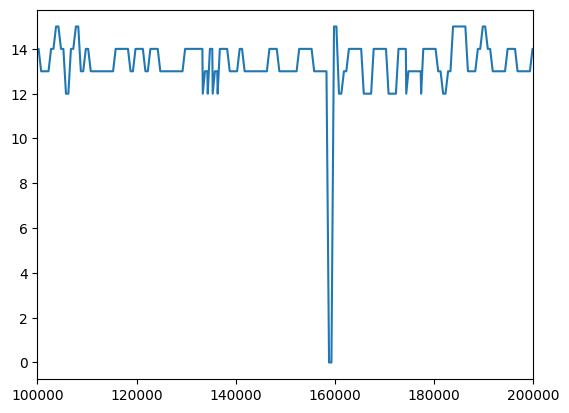

In [3]:
dfa = df[df["DONE"] < 0.5]
print(dfa["RLSB"].mean())
print(dfa["RLSB"].std())
plt.plot(dfa["RLSB"])

plt.xlim(100000,200000)

(10.0, 14.0)

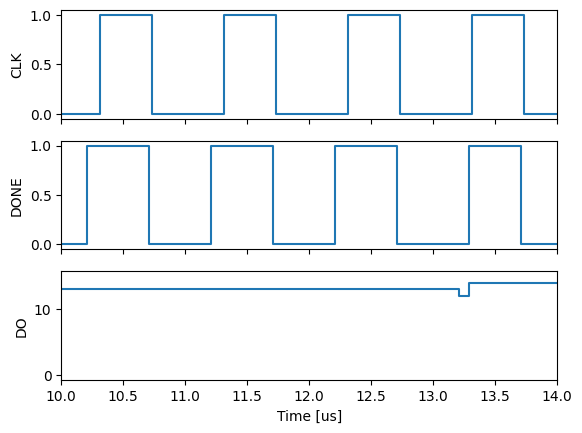

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(3,1,sharex=True)
ax[0].step(df.us,df["CLK"])
ax[0].set_ylabel("CLK")
ax[1].step(df.us,df["DONE"])
ax[1].set_ylabel("DONE")
ax[2].step(df.us,df["RLSB"])
ax[2].set_ylabel("DO")
plt.xlabel("Time [us]")
plt.xlim(10,14)


# 2024-11-08

Got some more data from Sylvain

## Sine

Not sure I got the sampling correct. I should really check the digital when done falls. 

The funky harmonics could be kickback. Last time I saw this it helped to have 10 pF 1% caps between the inputs, and to ground [https://analogcmos.wordpress.com](https://analogcmos.wordpress.com)

In [5]:
df2 = pd.read_pickle("sar_sine_100kHz_500mV.pkl")
df2.set_index("time",inplace=True)
df2.index = pd.to_datetime(df2.index,unit='ns')

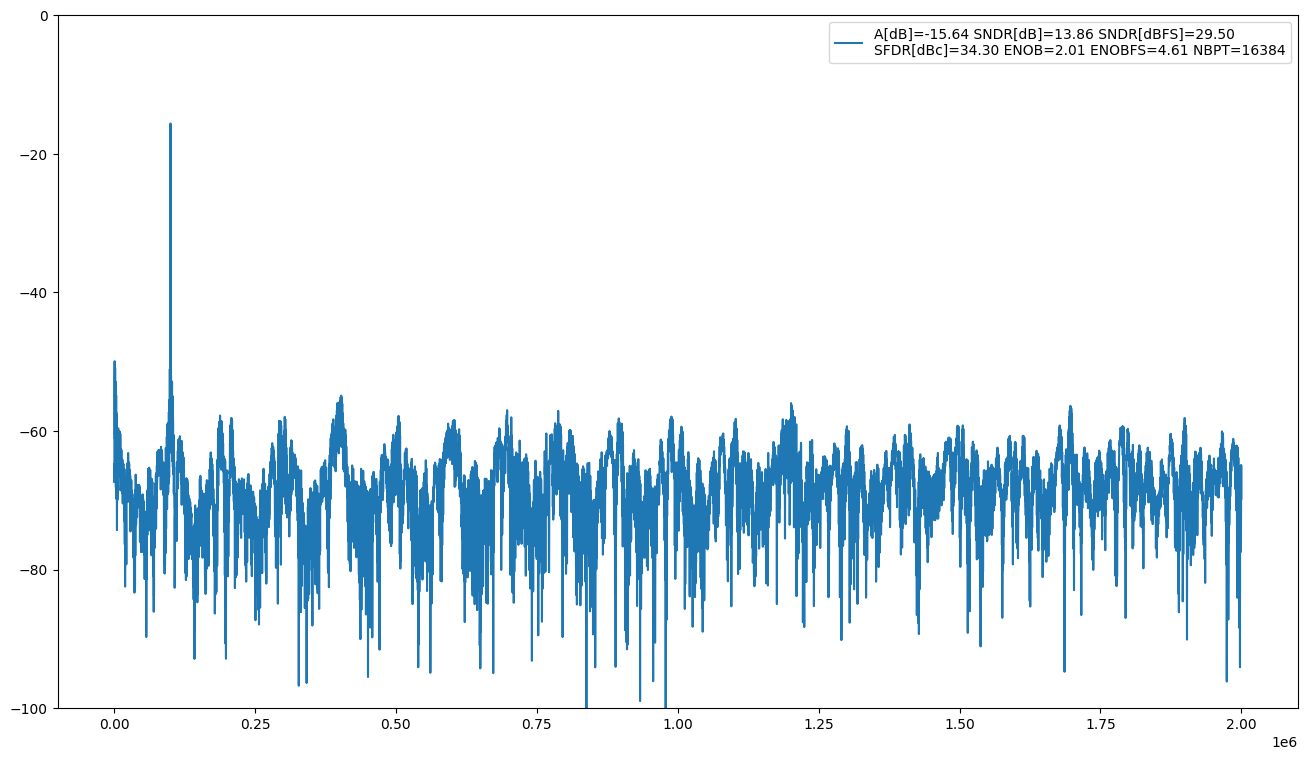

In [6]:
import cicsim as cs # I'm using latest and greatest cicsim, and if it does not work, then I might not have updated pypi
import numpy as np
def paramToStr(data):
    return "A[dB]=%.2f SNDR[dB]=%.2f SNDR[dBFS]=%.2f\nSFDR[dBc]=%.2f ENOB=%.2f ENOBFS=%.2f NBPT=%d" %(data["amp"],data["sndr"],data["sndrfs"],data["sfdr"],data["enob"],data["enobfs"],data["nbpt"])


def calc(df,tsample,name):
    o = df[name].iloc[1000:]
    oxx =  o.resample(pd.Timedelta(tsample,unit="ns")).first().ffill()
    scc = cs.SimCalc()
    data = None
    ydB = None
    (data,ydB)   = scc.fftWithHanning(oxx.to_numpy())
    x = np.linspace(0,0.5*1/(tsample*1e-9),num=int(data["nbpt"]/2))
    return (data,ydB,oxx,x)

fig,ax = plt.subplots(1,1,figsize=(16,9))
ax = [ax]
data,yff,y,x = calc(df2,1/4*1e3,"val")
ax[0].plot(x,yff,label=paramToStr(data))
ax[0].set_ylim(-100,0)
#plt.xscale("log")
ax[0].legend()

## Noise

The noise level seems OK. 7 ENOB referred to full scale does not sound too bad.

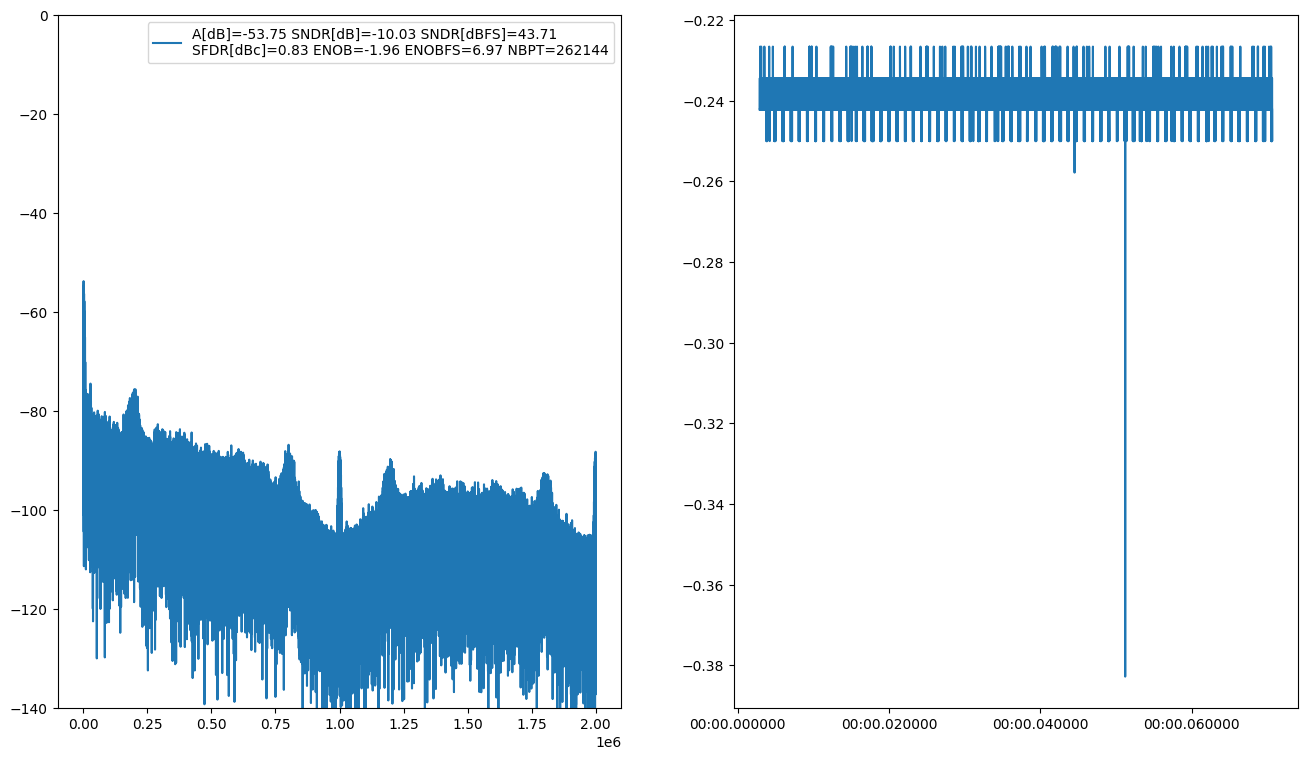

In [7]:

df3 = pd.read_pickle("sar_idle.pkl")
df3.set_index("time",inplace=True)
df3.index = pd.to_datetime(df3.index,unit='ns')
data,yff,y,x = calc(df3,1/4*1e3,"val")
fig,ax = plt.subplots(1,2,figsize=(16,9))
ax[0].plot(x,yff,label=paramToStr(data))
ax[1].plot(y)
ax[0].set_ylim(-140,0)
ax[0].legend()